In [2]:
import pandas as pd
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [5]:
import os
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'
# Define root domain to crawl
domain = "trustedtarot.com"
full_url = "https://trustedtarot.com/cards"

# Create a list to store the text files
texts=[]
# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[17:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/8v/dvjm79453xx0ft_dn74t6hvm0000gy/T/ipykernel_43954/3211554468.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,cards ace of cups,cards ace of cups. Ace of Cups Tarot Card Me...
1,cards page of wands,cards page of wands. Page of Wands Tarot Car...
2,cards six of pentacles,cards six of pentacles. Six of Pentacles Tar...
3,cards the star,cards the star. The Star Tarot Card Meaning ...
4,cards queen of swords,cards queen of swords. Queen of Swords Tarot...


<Axes: >

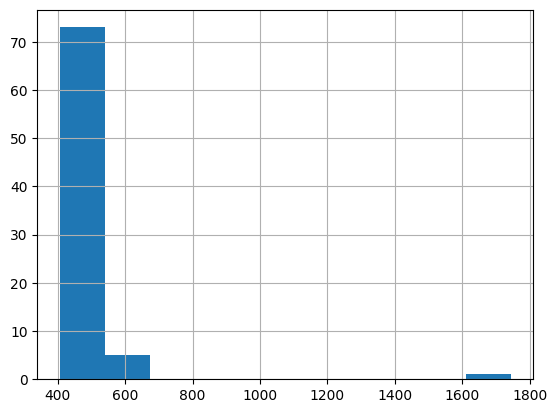

In [14]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [15]:
max_tokens = 500
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

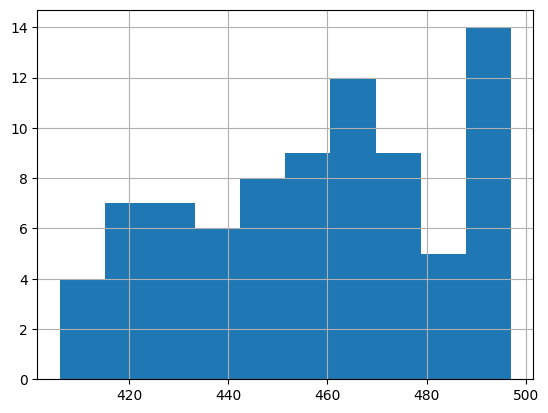

In [16]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [17]:
import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,cards ace of cups. Ace of Cups Tarot Card Me...,416,"[-0.008158287033438683, -0.030885860323905945,..."
1,cards page of wands. Page of Wands Tarot Car...,406,"[-0.007015338633209467, -0.03708387911319733, ..."
2,cards six of pentacles. Six of Pentacles Tar...,451,"[-0.006672652438282967, -0.03909282758831978, ..."
3,cards the star. The Star Tarot Card Meaning ...,422,"[0.0032862736843526363, -0.03967738151550293, ..."
4,cards queen of swords. Queen of Swords Tarot...,459,"[-0.01770767942070961, -0.030644915997982025, ..."


In [3]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,cards ace of cups. Ace of Cups Tarot Card Me...,416,"[-0.008272911421954632, -0.0311904177069664, 0..."
1,cards page of wands. Page of Wands Tarot Car...,406,"[-0.006989690475165844, -0.03700809180736542, ..."
2,cards six of pentacles. Six of Pentacles Tar...,451,"[-0.006632339209318161, -0.039083659648895264,..."
3,cards the star. The Star Tarot Card Meaning ...,422,"[0.003152291290462017, -0.03957458958029747, -..."
4,cards queen of swords. Queen of Swords Tarot...,459,"[-0.017610741779208183, -0.030660053715109825,..."


In [18]:
def create_context(
    question, df, max_len=100, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [19]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=10,
    size="ada",
    debug=False,
    max_tokens=20,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0.7,
            max_tokens=max_tokens,
            top_p=0.2,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [20]:
import openai
answer_question(df)

'No, you are not allowed to publish model outputs to Twitter without a human review. It is important'

In [21]:
answer_question(df, question="What day is it?", debug=False)

Context:






'Today is [day of the week].'

In [8]:
answer_question(df, question="What is The Fool?", debug=False)

"The Fool is a character in William Shakespeare's play, King Lear. He is a jester who"

In [9]:
answer_question(df, question="If I get in The Pool Card, will what I do next succeed?")

'It depends on the specific goals you have and the actions you take. The Pool Card can provide you'